In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / (1024 ** 2) 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / (1024 ** 2)
    print(f"start_mem Memory usage of df_train: {start_mem:.2f} MB")
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df_train_trans = pd.read_csv('../input/train_transaction.csv')
df_train_identity = pd.read_csv('../input/train_identity.csv')

df_train = df_train_trans.merge(df_train_identity, how='left', on='TransactionID')

print(df_train.shape)
del df_train_trans, df_train_identity

(590540, 434)


In [4]:
df_train = reduce_mem_usage(df_train)    

start_mem Memory usage of df_train: 2513.97 MB
Mem. usage decreased to 1204.57 Mb (52.1% reduction)


In [5]:
# Label encoding for categorical features
for col in df_train.select_dtypes(include='object').columns:
    lbl = LabelEncoder()
        
    encoded_values = lbl.fit_transform(df_train[col]) 
        
    #Replace the NaN (which becomes -1 after LabelEncoding) with -999
    encoded_values[df_train[col].isnull()] = -999
        
    # Step 5: Assign the encoded values back to the column
    df_train[col] = encoded_values

df_train.fillna(-999, inplace=True)
percent_missing = (df_train == -999).mean() * 100

# Identify columns where more than 50% of the values are missing
cols_to_drop = percent_missing[percent_missing > 50].index

cols_to_keep = ['R_emaildomain', 'DeviceInfo', 'DeviceType', 'D5', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'dist1', 'dist2', 'id_31', 'id_30', 'M5', 'M7', 'M8', 'M9']
cols_to_drop = cols_to_drop.drop(cols_to_keep, errors='ignore') # Exclude 'R_emaildomain' from dropping

# Drop these columns
df_train_cleaned = df_train.drop(columns=cols_to_drop)

remove_columns = ['M4']
# Drop these columns
df_train_cleaned = df_train_cleaned.drop(columns=remove_columns)

# Display the cleaned dataframe
print(f"Columns removed: {cols_to_drop}")
print(f"Shape of the cleaned dataframe: {df_train_cleaned.shape}")

Columns removed: Index(['V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146',
       'V147',
       ...
       'id_27', 'id_28', 'id_29', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
       'id_37', 'id_38'],
      dtype='object', length=195)
Shape of the cleaned dataframe: (590540, 238)


In [6]:
df_train_cleaned = df_train_cleaned.drop('TransactionID', axis=1)

# Select only numerical columns
X_train = df_train_cleaned.drop(columns=['isFraud'])
y_train = df_train_cleaned['isFraud']

# Train-test split (80% train, 20% validation)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [7]:
# Apply StandardScaler (fit only on train, transform on both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val)

# Initialize PCA and specify number of components (optional)
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

Training Performance:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    455902
           1       0.84      0.39      0.54     16530

    accuracy                           0.98    472432
   macro avg       0.91      0.70      0.76    472432
weighted avg       0.97      0.98      0.97    472432

Validation Performance:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99    113975
           1       0.71      0.28      0.41      4133

    accuracy                           0.97    118108
   macro avg       0.84      0.64      0.70    118108
weighted avg       0.97      0.97      0.96    118108



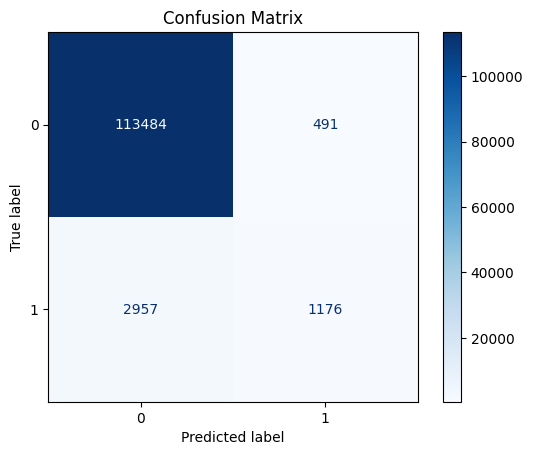

In [8]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_pca, y_train_final)

y_train_pred = knn.predict(X_train_pca)
print("Training Performance:\n", classification_report(y_train_final, y_train_pred))

# Predictions on validation data
y_val_pred = knn.predict(X_val_pca)
print("Validation Performance:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [4]:
correlation_matrix = df_train.corr()

# Step 2: Get the correlation of all features with the target variable ('isFraud' in this example)
target_correlation = correlation_matrix['isFraud']

top_100_features = target_correlation.abs().sort_values(ascending=False).head(100)
top_100_feature_names = top_100_features.index

# Step 5: Select the corresponding columns from the original DataFrame
df_top_100 = df_train[top_100_feature_names]

# Show the resulting DataFrame with the top 100 correlated features
print(df_top_100)

ValueError: could not convert string to float: 'W'

In [ ]:
for f in df_train.drop('isFraud', axis=1).columns:
     if df_train[f].dtype=='object': 
         lbl = LabelEncoder()
         lbl.fit(df_train[f].values)
         df_train[f] = lbl.transform(list(df_train[f].values))

df_train.fillna(-999, inplace=True)


y_train = df_train['isFraud']  # This is the target variable

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Apply StandardScaler (fit only on train, transform on both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val)

# Initialize PCA and specify number of components (optional)
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)


Accuracy with k=5: 0.9715
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.72      0.31      0.43      4133

    accuracy                           0.97    118108
   macro avg       0.85      0.65      0.71    118108
weighted avg       0.97      0.97      0.97    118108



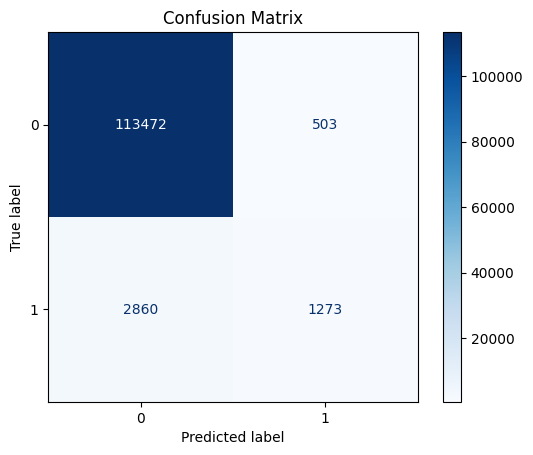

In [12]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train_pca, y_train_final)
y_val_pred = knn.predict(X_val_pca)

accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy with k={5}: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix (useful for imbalanced classes like fraud detection)
cm = confusion_matrix(y_val, y_val_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap='Blues')  # 'Blues' colormap for better readability
plt.title('Confusion Matrix')
plt.show()